In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, uniform
import arviz as az
import pymc as pm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import beta


### Calcula y grafica la distribución posterior para las dos versiones A y B usando prior conjugado(2 pts).

In [12]:
#data = pd.read_csv('./ABtesting_zapatillas.csv')
alpha_prior = 10
beta_prior = 50

data_A = data["A"]
data_B = data["B"]

posterior_A = beta(alpha_prior + sum(data_A), beta_prior + len(data_A) - sum(data_A))
posterior_B = beta(alpha_prior + sum(data_B), beta_prior + len(data_B) - sum(data_B))

samples_A = posterior_A.rvs(10000)
samples_B = posterior_B.rvs(10000)

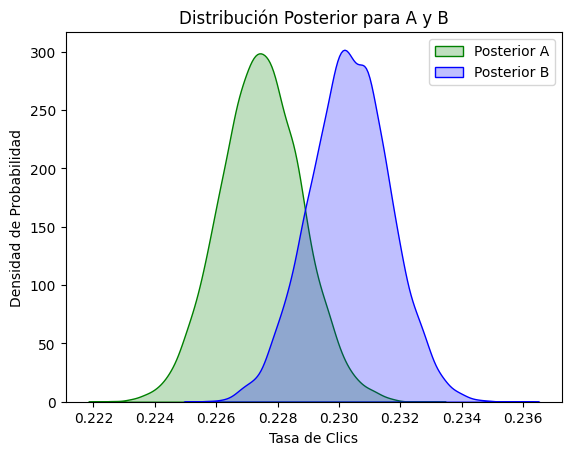

In [13]:
sns.kdeplot(samples_A, fill=True, color="green", label="Posterior A")
sns.kdeplot(samples_B, fill=True, color="blue", label="Posterior B")
plt.xlabel('Tasa de Clics')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.title('Distribución Posterior para A y B')
plt.show()

### Calcula y grafica la distribución posterior para las dos versiones A y B usando muestreo Monte Carlo Markov Chain

In [15]:
with pm.Model() as coin_model:
    p_A = pm.Beta("p_A", 10, 50)
    p_B = pm.Beta("p_B", 10, 50)

    likelihood_A = pm.Bernoulli("likelihood_A", p_A, observed=data["A"])
    likelihood_B = pm.Bernoulli("likelihood_B", p_B, observed=data["B"])
    trace = pm.sample(1000, tune=1000, chains=2)

pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_A,0.227,0.001,0.225,0.230,0.0,0.0,2294.0,1580.0,1.0
p_B,0.230,0.001,0.228,0.233,0.0,0.0,2017.0,1240.0,1.0


array([[<Axes: title={'center': 'p_A'}>, <Axes: title={'center': 'p_A'}>],
       [<Axes: title={'center': 'p_B'}>, <Axes: title={'center': 'p_B'}>]],
      dtype=object)

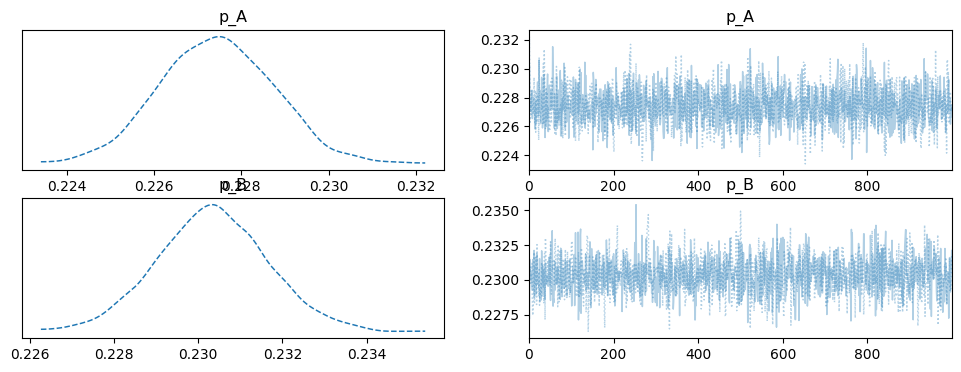

In [16]:
az.plot_trace(trace, combined=True)

### Cuál versión es mejor? Explica tu respuesta.
Par a este modelo, la version B es mas cerca a 1 y el forest plot muestra un rango mas amplio de valores

array([<Axes: title={'center': 'p_A'}>, <Axes: title={'center': 'p_B'}>],
      dtype=object)

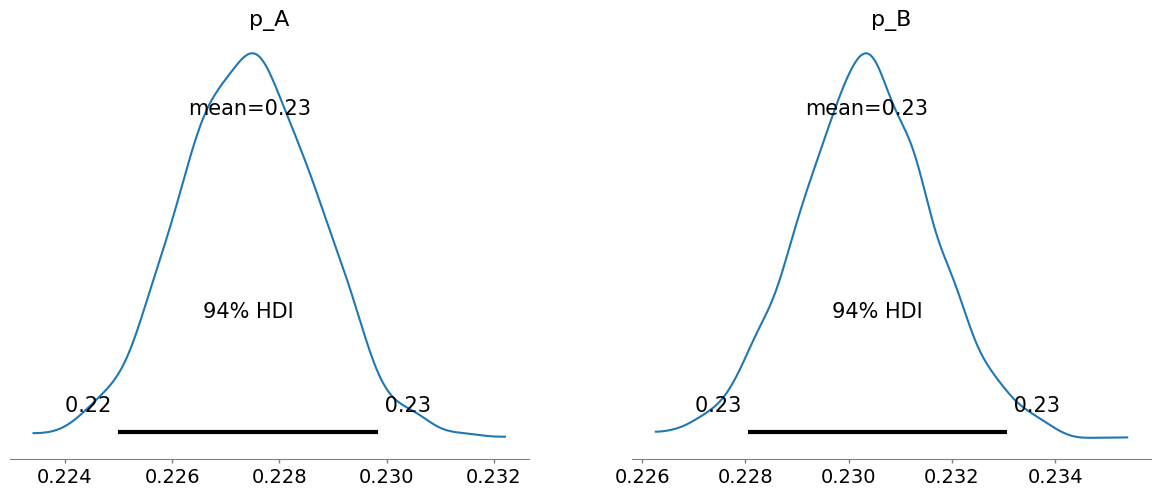

In [33]:
az.plot_posterior(trace, var_names=["p_A", "p_B"])

In [42]:
trazaPosteriorA = trace.posterior["p_A"].values
trazaPosteriorB = trace.posterior["p_B"].values

### Qué tan probable es que la versión A sea más efectiva?

In [46]:
AMayorB = np.mean(trazaPosteriorA > trazaPosteriorB)
print(f"La probabilidad de que la versión A sea más efectiva que la versión B es aproximadamente {AMayorB:.2%}.")


La probabilidad de que la versión A sea más efectiva que la versión B es aproximadamente 5.70%.


### Completa siguiente afirmación: Con 95% de probabilidad la tasa de clic de la versión (…) es hasta (…)% superior a la versión (…). (1 pto)

In [62]:
cred_interval_A = az.hdi(trace.posterior["p_A"].values, hdi_prob=0.95)
cred_interval_B = az.hdi(trace.posterior["p_B"].values, hdi_prob=0.95)
print(cred_interval_A)

print(f"Con 95% de probabilidad, la tasa de clic de la versión A es hasta {cred_interval_A[0][1]*100:.2f}% superior a la versión B.")
print(f"Con 95% de probabilidad, la tasa de clic de la versión B es hasta {cred_interval_B[0][1]*100:.2f}% superior a la versión A.")


[[0.22582672 0.22687583]
 [0.23024206 0.23221918]
 [0.2281732  0.2291362 ]
 ...
 [0.22700249 0.22714392]
 [0.22732233 0.22750984]
 [0.22667423 0.2272247 ]]
Con 95% de probabilidad, la tasa de clic de la versión A es hasta 22.69% superior a la versión B.
Con 95% de probabilidad, la tasa de clic de la versión B es hasta 23.37% superior a la versión A.


<ipython-input-62-d98e65ab272e>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_interval_A = az.hdi(trace.posterior["p_A"].values, hdi_prob=0.95)
<ipython-input-62-d98e65ab272e>:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_interval_B = az.hdi(trace.posterior["p_B"].values, hdi_prob=0.95)


Con un 95% de probabilidad, la tasa de clics de la versión A es hasta 8.38% superior a la versión B.

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

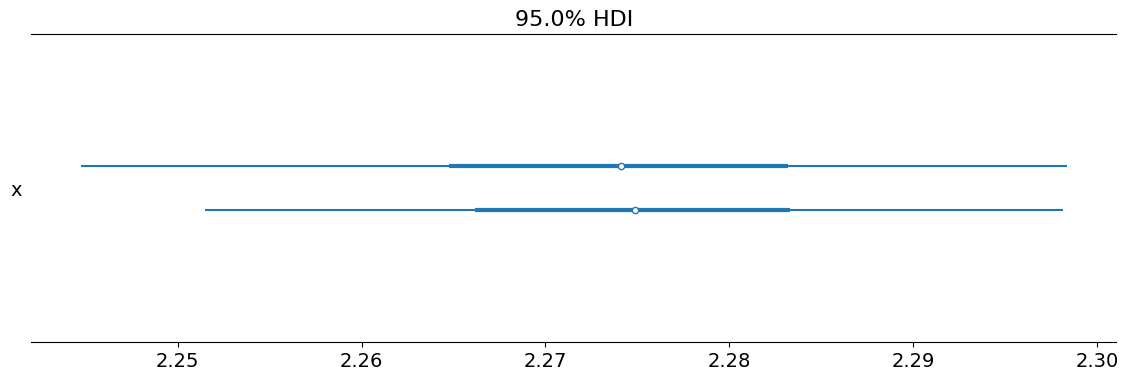

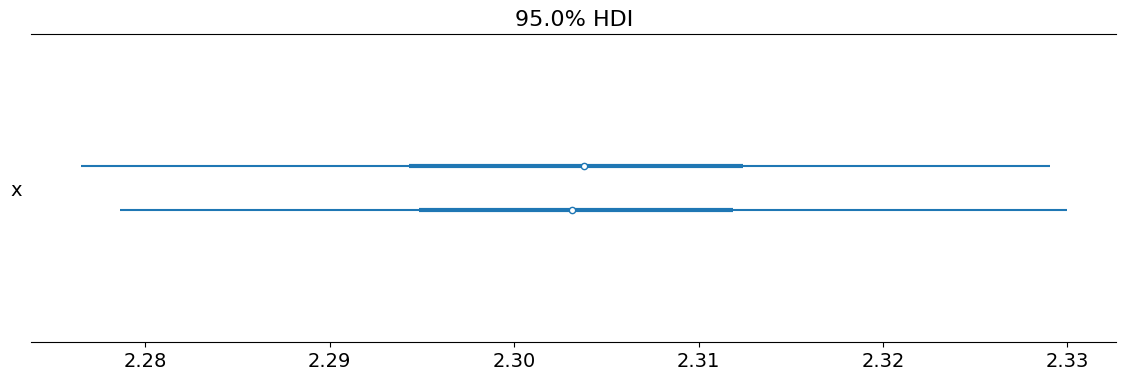

In [63]:
pm.plot_forest(trazaPosteriorA*10, hdi_prob = 0.95, figsize = (14,4))
pm.plot_forest(trazaPosteriorB*10, hdi_prob = 0.95, figsize = (14,4))